# Dataproject

# 1. Aggregate inflation in Denmark

## 1.1

We start by getting the import and API reader

In [20]:
#!pip install numpy
#!pip install matplotlib
#%pip install git+https://github.com/alemartinello/dstapi
#%pip install fredapi
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# APIs
from fredapi import Fred
from dstapi import DstApi

Then we get our data, which is made in finaldata.ipynb, and then converted to a csv in CPI.csv

In [21]:
#imports dataset from finaldata
df = pd.read_csv("cpi.csv")

Calculating month to month and year to year, and covenrting to pandas format

In [22]:
# converts time to pandas datetime and sorts values
df['TID'] = pd.to_datetime(df['TID'])
df = df.sort_values('TID')

# makes sure INDHOLD is numeric
df['INDHOLD'] = pd.to_numeric(df['INDHOLD'], errors='coerce')

# index 2020 = 100
avg2020 = df.loc[df['TID'].dt.year == 2020, 'INDHOLD'].mean()
df['INDEX2020'] = df['INDHOLD'] / avg2020 * 100

# calculates month-to-month and year-over-year inflation rates
df['m2m_inflation'] = df['INDEX2020'].pct_change() * 100       # month to month
df['yoy_inflation'] = df['INDEX2020'].pct_change(12) * 100     # 12 months

Then we can make our graphs:

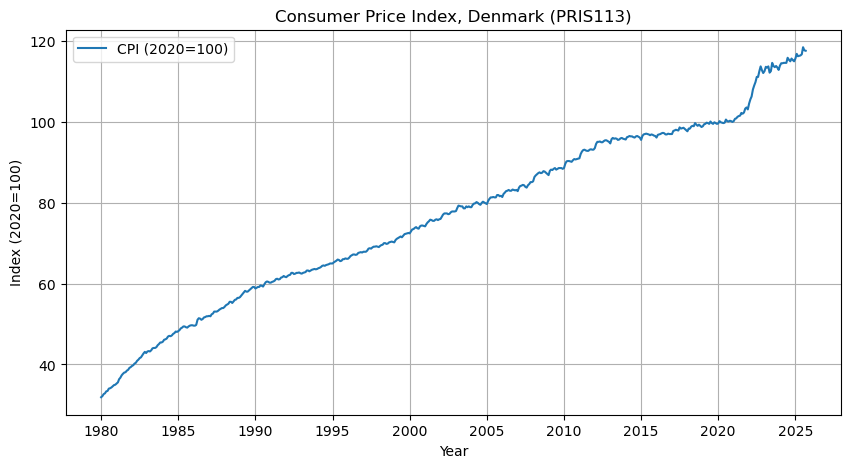

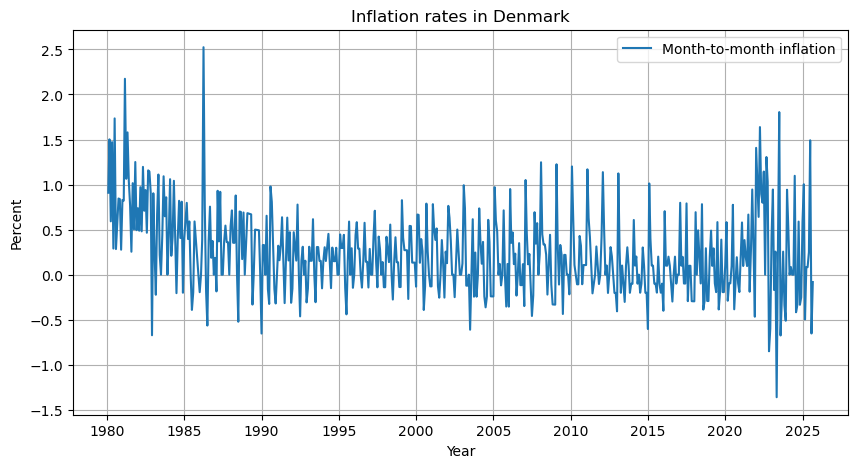

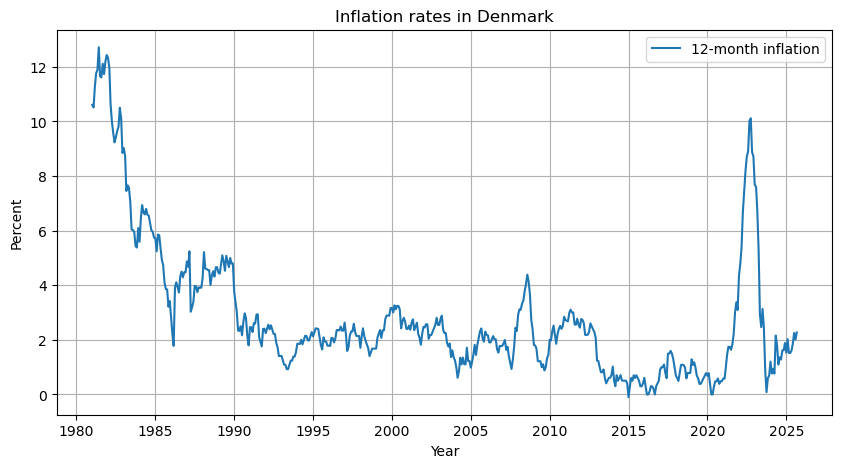

In [23]:
#making the graphs 

# plotting CPI with 2020 as base year
plt.figure(figsize=(10,5))
plt.plot(df['TID'], df['INDEX2020'], label='CPI (2020=100)')
plt.title('Consumer Price Index, Denmark (PRIS113)')
plt.xlabel('Year')
plt.ylabel('Index (2020=100)')
plt.legend()
plt.grid(True)
plt.show()

# Plotting monthly inflation rates 
plt.figure(figsize=(10,5))
plt.plot(df['TID'], df['m2m_inflation'], label='Month-to-month inflation')
plt.title('Inflation rates in Denmark')
plt.xlabel('Year')
plt.ylabel('Percent')
plt.legend()
plt.grid(True)
plt.show()

# Plotting yearly inflation rates
plt.figure(figsize=(10,5))
plt.plot(df['TID'], df['yoy_inflation'], label='12-month inflation')
plt.title('Inflation rates in Denmark')
plt.xlabel('Year')
plt.ylabel('Percent')
plt.legend()
plt.grid(True)
plt.show()

# 1.2 - Instataneous inflation

## 1.2.1


We start by defining k and alpha, and the plotting for alpha values

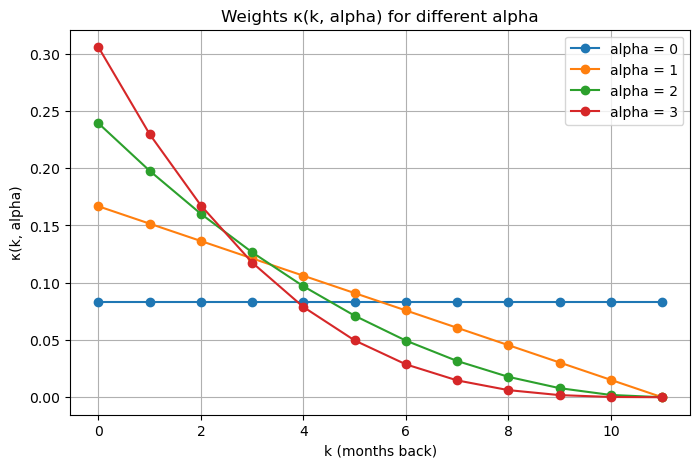

In [24]:
# Defining k and alpha
def kappa(alpha):
    T = 11  # The maximum lag (11 months back)
    ks = np.arange(0, 12)
    weights = (T - ks) ** alpha
    weights = weights / weights.sum()  # normalizing the weights so, that they sum to 1
    return ks, weights

# Plot for α = 0, 1, 2, 3
alphas = [0, 1, 2, 3]
plt.figure(figsize=(8, 5))

for a in alphas:
    ks, w = kappa(a)
    plt.plot(ks, w, marker='o', label=f'alpha = {a}')

plt.xlabel('k (months back)')
plt.ylabel('κ(k, alpha)')
plt.title('Weights κ(k, alpha) for different alpha')
plt.legend()
plt.grid(True)
plt.show()

## 1.2.2

We start by defining the function for instateneous inflation, and then defining the weights

In [25]:
#Defining the function for instantaneous inflation
def instantaneous_over_window(window, alpha):
    # weights
    w = (np.arange(1, 13) ** alpha).astype(float)
    w = w / w.sum()
    return np.prod((1.0 + window) ** w) - 1.0


In [26]:
alphas = [0, 1, 2, 3]

# calculates month-to-month inflation rates
df['m2m_inflation'] = df['INDHOLD'].pct_change() * 100       # month to month

In [27]:
#Defining the weights
def weights(alpha):
    k = np.arange(12)
    T = 11
    w = (T - k)**alpha
    return w / w.sum()

Calculating the instataneous inflation rate

In [ ]:
#Calculating the instantaneous inflation rate, Brugt AI
# Define instantaneous inflation calculation 
def inst_inflation_raw(window, alpha):
    vals = np.asarray(window, dtype=float) / 100.0
    if np.isnan(vals).any():
        return np.nan
    w = weights(alpha)[::-1]        # align weights (recent months get more weight)
    return np.exp(np.dot(np.log1p(vals), w)) - 1.0

# Calculate π₁₂,ₐ,ₜ for α = 0, 1, 2, 3
for alpha in [0, 1, 2, 3]:
    df[f"pi_12_alpha_{alpha}"] = (
        df["m2m_inflation"]
          .rolling(window=12, min_periods=12)
          .apply(inst_inflation_raw, raw=True, args=(alpha,))
          * 100
    )


## 1.2.3

Making the graph since 2019

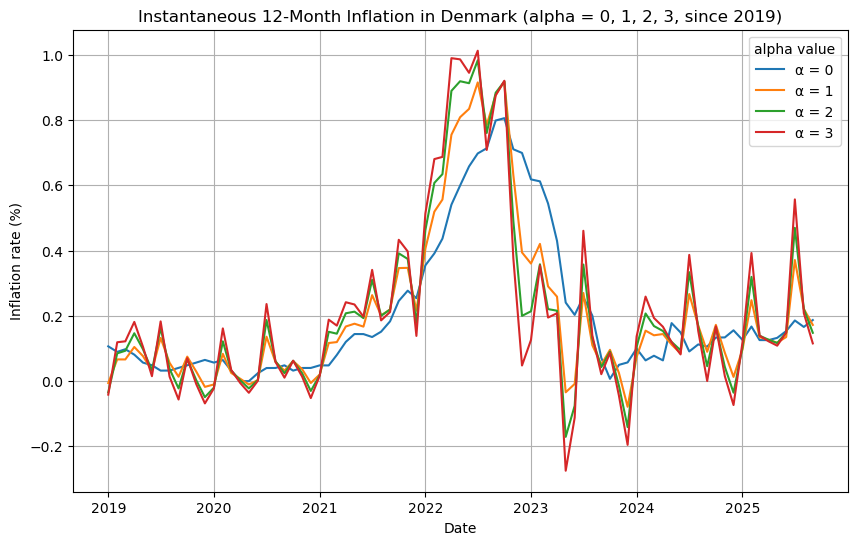

In [29]:
# filter data from 2019 and onward
df_2019 = df[df["TID"] >= "2019-01-01"]

plt.figure(figsize=(10,6))

for alpha in [0, 1, 2, 3]:
    plt.plot(df_2019["TID"], df_2019[f"pi_12_alpha_{alpha}"], label=f"α = {alpha}")

plt.title("Instantaneous 12-Month Inflation in Denmark (alpha = 0, 1, 2, 3, since 2019)")
plt.xlabel("Date")
plt.ylabel("Inflation rate (%)")
plt.legend(title="alpha value")
plt.grid(True)
plt.show()
